In [5]:
import pod5
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/NEMO/src/')
from predict import *
from plot import *
import importlib
from qc import *
from findWellPosGenes import *
importlib.reload(sys.modules['findWellPosGenes'])
from findWellPosGenes import *

In [6]:
from tqdm import tqdm

In [7]:
dt_outpath = '../data/'
fig_outpath = '../figures/'

In [9]:
# read well positioned genes
nuclei_rep3 = '../data/4_dorado_20220331_chrom_well_positioned_genes_cov40_cor0.5_var6800.bed'
nuclei_rep3_gene ={}
with open(nuclei_rep3) as infile:
    for line in infile:
        line=line.strip().split('\t')
        chr, start, end, genename, strand = line[0], line[1], line[2], line[3], line[5]
        nuclei_rep3_gene[(genename, strand)] = f'{chr}:{start}-{end}'
print(f'n genes: {len(nuclei_rep3_gene)}')

n genes: 59


In [12]:
top = 30
pregions ={}
i = 0
for gene in nuclei_rep3_gene:
    pregions[gene] = nuclei_rep3_gene[gene]
    i+=1
    if i ==top:
        break

outf = open(f'6_rep3_well_positioned_genes_top_{top}.tsv', 'w')
for gene in pregions:
    outf.write(f'{gene}\n')

In [13]:
# get single reads
predfile = '../data/prediction/240909_dorado_20220331_chrom.tsv'
strand = ''
outpath = dt_outpath
na_thred = 0.2
max_meth = 200
prefix = f'6_rep3_well_positioned_genes_top_{top}'
stranded = False
mtx, readnames, strands, genenames = [], [], [], []

for (genename, strand), pregion in pregions.items():
    
    print(f'start processing gene {genename}...')
    
    chrom = pregion.split(':')[0]
    locus = pregion.split(':')[1].split('-')
    pstart, pend = int(locus[0]), int(locus[1])
    with open(predfile, 'r') as infile:
        for line in tqdm(infile):
            thischrom = line.strip().split('\t')[1]
            if thischrom!= chrom:
                continue
            thisread = line.strip().split('\t')[0]
            thisstrand = 1 if line.strip().split('\t')[2] == '+' else -1
            if stranded:
                if thisstrand != strand:
                    continue
            start = int(line.strip().split('\t')[3])
            scores = line.strip().split('\t')[-1]
            scores = [float(i) for i in scores.split(',')]
            
            sortedread = [(start+i,j) for i, j in enumerate(scores)]
            if sortedread[0][0] > pend or sortedread[-1][0] < pstart: continue
            
            pos_scores = {i:-1 for i in range(pstart, pend+1)}
            poss = [i[0] for i in sortedread]
            
            left = bisect_left(poss, pstart)
            
            for i in range(left, len(sortedread)):
                pos, score = sortedread[i]
                if pos > pend:
                    break
                if pos not in pos_scores:
                    continue
                pos_scores[pos] = score
            
            thisscores = np.array([v for v in pos_scores.values()])
            # flip if the gene is on reverse strand
            thisscores = np.flip(thisscores) if strand == '-' else thisscores
            
            if np.sum(thisscores) != -1*len(thisscores):
                mtx.append(thisscores)
                readnames.append(thisread)
                strands.append(thisstrand)
                genenames.append(genename)
    print(f'finished processing gene {genename}...')

mtx = np.array(mtx, dtype = float)
mtx[mtx==-1] = np.nan
readnames = np.array(readnames, dtype = str)
strands = np.array(strands, dtype = int)
genenames = np.array(genenames, dtype = str)

print('number of reads before filtering:', len(readnames))
print(f'filtering reads with more than {na_thred} NA...')
little_na = np.invert(np.isnan(mtx).sum(axis = 1)>(mtx.shape[1]*na_thred))
mtx = mtx[little_na,:]
readnames = readnames[little_na]
strands = strands[little_na]
genenames = genenames[little_na]
print(f'number of reads kept: {len(readnames)}', )
print(f'filtering hyper-methylated reads...')
hyper_meth= np.invert(np.nanmean(mtx, axis = 1)>max_meth)
mtx = mtx[hyper_meth,:]
readnames = readnames[hyper_meth]
strands = strands[hyper_meth]
genenames = genenames[hyper_meth]
print(f'number of reads kept: {len(readnames)}')

outfile = outpath + prefix + '.mtx'
print('writing output to file: ', outfile)
mtxFh = open(outfile, 'w')
for line in mtx:
    mtxFh.write(','.join(np.array(line, dtype = str)) + '\n')
mtxFh.close()

outfile2 = outpath + prefix + '_rowannot.tsv'
outf = open(outfile2, 'w')
for i,j,k in zip(readnames, strands, genenames):
    outf.write(f'{i}\t{j}\t{k}\n')
outf.close()

179it [00:00, 1789.52it/s]

start processing gene RPL5...


61818it [00:31, 1969.21it/s]
708it [00:00, 7075.84it/s]

finished processing gene RPL5...
start processing gene TAT2...


61818it [00:28, 2199.63it/s]
714it [00:00, 7124.18it/s]

finished processing gene TAT2...
start processing gene PEP8...


61818it [00:40, 1528.50it/s]
734it [00:00, 7318.37it/s]

finished processing gene SLF1...
start processing gene CBP1...


61818it [00:21, 2870.06it/s]
686it [00:00, 6859.07it/s]

finished processing gene CBP1...
start processing gene GND2...


61818it [00:28, 2136.80it/s]
703it [00:00, 7024.61it/s]

finished processing gene GND2...
start processing gene POF1...


61818it [00:13, 4663.28it/s]
702it [00:00, 7012.40it/s]

finished processing gene POF1...
start processing gene ASI3...


61818it [00:27, 2273.63it/s]
734it [00:00, 7324.45it/s]

finished processing gene ASI3...
start processing gene NTR2...


61818it [00:22, 2743.02it/s]
726it [00:00, 7256.44it/s]

finished processing gene NTR2...
start processing gene CBF2...


61818it [00:27, 2227.71it/s]
734it [00:00, 7308.16it/s]

finished processing gene CBF2...
start processing gene TOR2...


61818it [00:25, 2461.36it/s]
714it [00:00, 7136.43it/s]

finished processing gene TOR2...
start processing gene ENV9...


61818it [00:38, 1600.84it/s]
712it [00:00, 7115.36it/s]

finished processing gene ENV9...
start processing gene SPS22...


61818it [00:21, 2815.94it/s]
704it [00:00, 7035.11it/s]

finished processing gene SPS22...
start processing gene GRX2...


61818it [00:43, 1415.88it/s]
708it [00:00, 7074.10it/s]

finished processing gene GRX2...
start processing gene ALR2...


61818it [00:13, 4474.94it/s]
705it [00:00, 7048.07it/s]

finished processing gene ALR2...
start processing gene RSC6...


61818it [00:13, 4594.25it/s]
714it [00:00, 7139.94it/s]

finished processing gene RSC6...
start processing gene HVG1...


61818it [00:19, 3251.78it/s]
706it [00:00, 7058.68it/s]

finished processing gene HVG1...
start processing gene zz-YER039C-A...


61818it [00:18, 3307.10it/s]
709it [00:00, 7080.65it/s]

finished processing gene zz-YER039C-A...
start processing gene ATG31...


61818it [00:38, 1596.08it/s]
710it [00:00, 7091.38it/s]

finished processing gene ATG31...
start processing gene RCF1...


61818it [00:24, 2535.80it/s]
707it [00:00, 7067.28it/s]

finished processing gene RCF1...
start processing gene KTR2...


61818it [00:20, 2988.18it/s]
710it [00:00, 7092.47it/s]

finished processing gene KTR2...
start processing gene ELG1...


61818it [00:28, 2200.42it/s]
699it [00:00, 6979.76it/s]

finished processing gene ELG1...
start processing gene YEF3...


44460it [00:47, 246.77it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
import pandas as pd
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.impute import SimpleImputer

if np.isnan(mtx).sum() != 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    new_mtx = imp.fit_transform(mtx)
else:
    new_mtx = mtx

df = pd.DataFrame(new_mtx)
df['gene'] = genenames  # Add the gene annotation to the matrix as a new column

# Group the matrix by gene
grouped_by_gene = df.groupby('gene')

# Function for KMeans clustering for each gene
def kmeans_clustering_for_gene(gene_group, n_clusters=3):
    # Exclude the 'gene' column for clustering
    gene_reads = gene_group.drop(columns=['gene'])
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(gene_reads)
    
    # Add the cluster labels as a new column
    gene_group['cluster'] = clusters
    
    # Sort the rows by cluster labels
    sorted_gene_group = gene_group.sort_values(by='cluster')
    
    return sorted_gene_group.drop(columns=['cluster'])  # Drop the cluster column after sorting

# Function for hierarchical clustering for each gene
def hierarchical_clustering_for_gene(gene_group, method='ward', n_clusters=3):
    # Exclude the 'gene' column for clustering
    gene_reads = gene_group.drop(columns=['gene'])
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(gene_reads, method=method)
    
    # Get the flat clusters based on n_clusters
    clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    
    # Add the cluster labels as a new column
    gene_group['cluster'] = clusters
    
    # Sort the rows by cluster labels
    sorted_gene_group = gene_group.sort_values(by='cluster')
    
    return sorted_gene_group.drop(columns=['cluster'])  # Drop the cluster column after sorting

# 1. Apply clustering on each gene group and collect sorted groups
sorted_groups, clustered_genes = [], []

for gene_name, gene_group in grouped_by_gene:
    print(f"Clustering for {gene_name}")
    
    # Choose KMeans or Hierarchical clustering
    sorted_gene_group = kmeans_clustering_for_gene(gene_group, n_clusters=3)
    # Alternatively, use hierarchical clustering:
    # sorted_gene_group = hierarchical_clustering_for_gene(gene_group, n_clusters=3)

    # Append the sorted group to the list
    sorted_groups.append(sorted_gene_group.drop(columns=['gene']))  # Remove 'gene' column

    clustered_genes.extend([gene_name] * len(sorted_gene_group))
# 2. Concatenate all sorted groups back into one matrix
clustered_mtx = pd.concat(sorted_groups, axis=0).values  # Convert to numpy array

# The final output matrix
print("clustered matrix shape:", clustered_mtx.shape)

Clustering for ALR2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Clustering for ASI3
Clustering for ATG31
Clustering for AVL9


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for CBF2
Clustering for CBP1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for COG6
Clustering for ELG1
Clustering for ENV9


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for ERG9
Clustering for GND2
Clustering for GRX2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for HVG1
Clustering for KTR2
Clustering for NTR2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for PEP8
Clustering for POF1
Clustering for RCF1


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for RPL5
Clustering for RQT4
Clustering for RSC6


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for SEC6
Clustering for SLF1
Clustering for SPS22


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for TAT2
Clustering for TFA1
Clustering for TFA2


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn

Clustering for TOR2
Clustering for YEF3
Clustering for zz-YER039C-A
clustered matrix shape: (1252, 1201)


/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/private/groups/brookslab/gabai/miniconda3/envs/addseq/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1252/1252 [24:13<00:00,  1.09s/it]


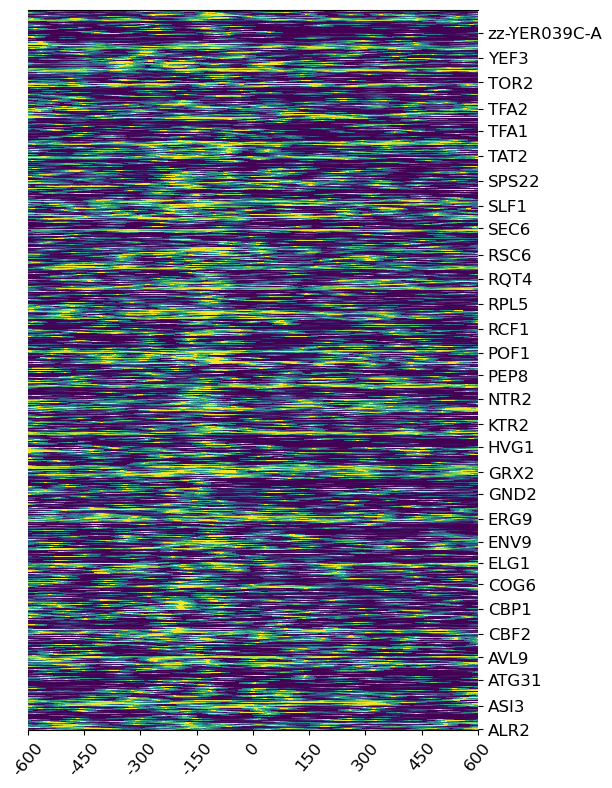

In [17]:
plt.figure(figsize=(5, 8))
pstart, pend = (-600, 600)
xticks_space = 150
ax = plt.axes((0.1, 0.1, 0.9, 0.9))
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(ticks= np.arange(pstart, pend+1, xticks_space))
ax.set_xticklabels(ax.get_xticks(), rotation = 50)
ax.set_xlim(pstart, pend)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
height = (1, 1)
bottom=0
tick_yaxis, label_yaxis = [],[]
total, count = np.zeros(clustered_mtx.shape[1], dtype = int), np.zeros(clustered_mtx.shape[1], dtype = int)
(R,G,B) = colorMap(palette = 'viridis', log_scale=False)
thisgene = ''

for i in tqdm(range(clustered_mtx.shape[0])):
    left = -600
    if thisgene != clustered_genes[i]:
        tick_yaxis.append(bottom)
        label_yaxis.append(clustered_genes[i])
        thisgene = clustered_genes[i]
    for j in range(clustered_mtx.shape[1]):
        score = clustered_mtx[i, j]
        if not np.isnan(score):
            count[j] += score
            total[j] += 1
        # no score at this position
        if np.isnan(score):
            col = 'lightgray'
        else:
            color = int((score/256)*100)
            col=(R[color],G[color],B[color])
        thisalpha = 1
        rectangle = mplpatches.Rectangle([left, bottom-(height[0]*0.5)], 1, height[0], 
                                         facecolor = col, edgecolor = 'silver', linewidth = 0, alpha=thisalpha)
        ax.add_patch(rectangle)
        left += 1
    bottom +=height[0]

aggregate = np.divide(np.divide(count, total), 256)
if np.max(total) < 1:
    aggregate = np.zeros(clustered_mtx.shape[1])
ax.bar(np.arange(pstart, pend+1), aggregate, bottom=bottom, width = 1.0, color = 'tab:blue')
bottom+=1
ax.set_yticks(ticks = tick_yaxis, labels = label_yaxis)
ax.set_ylim(0-0.5*height[0], bottom)

plt.savefig(fig_outpath+ f'6_top_{top}_well_positioned_genes_clustered_within_gene_rep3.pdf', bbox_inches='tight')

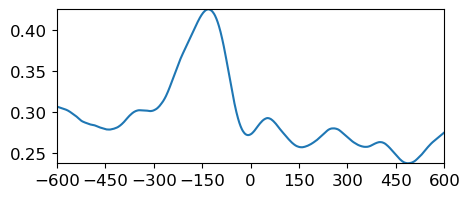

In [27]:
from scipy.signal import savgol_filter
smoothed_agg = savgol_filter(aggregate, 150, 3, mode="nearest")
plt.figure(figsize=(5, 2))
plt.plot(np.arange(pstart, pend+1), smoothed_agg)
plt.xticks(ticks= np.arange(pstart, pend+1, xticks_space))
plt.ylim(min(smoothed_agg), max(smoothed_agg))
plt.xlim(-600, 600)
plt.savefig(fig_outpath+ f'6_top_{top}_aggregated_panel_rep3.pdf', bbox_inches='tight')